# Project 0: Projection & Cartography Practice

**Geospatial Data Analysis Tutorial - Phase 1**

Welcome to your first geospatial data science project! This notebook will teach you fundamental concepts of coordinate reference systems (CRS), map projections, and cartographic design.

## 🎯 Learning Objectives

By the end of this notebook, you will:
- Understand coordinate reference systems and map projections
- Learn to transform geospatial data between different CRS
- Practice basic cartographic design principles  
- Master exporting publication-quality maps
- Establish a reproducible geospatial workflow

## 📊 What We'll Create

1. **Environment Setup** - Verify all packages work correctly
2. **Data Download** - Get Natural Earth datasets automatically
3. **Basic World Map** - Create your first geospatial visualization
4. **Projection Comparison** - See how different projections affect world appearance
5. **Regional Map** - Focus on North America with detailed cartography
6. **Quality Assurance** - Learn data validation procedures

Let's begin! 🚀

## 1. Environment Setup & Library Imports

First, let's import all the required libraries and verify our geospatial environment is working correctly.

In [1]:
# Core geospatial libraries
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon

# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

# Cartographic libraries
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Utility libraries
import os
import sys
import requests
import zipfile
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib for high-quality outputs
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

print("✅ All libraries imported successfully!")
print(f"GeoPandas version: {gpd.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Python version: {sys.version.split()[0]}")

✅ All libraries imported successfully!
GeoPandas version: 1.1.1
Pandas version: 2.3.1
Matplotlib version: 3.10.5
Python version: 3.11.6


## 2. Project Directory Setup

Let's set up our project directories following geospatial data science best practices.

In [2]:
# Define project paths
project_root = Path('..')
data_dir = project_root / 'data'
raw_data_dir = data_dir / 'raw'
processed_data_dir = data_dir / 'processed'
outputs_dir = project_root / 'outputs'
figures_dir = outputs_dir / 'figures'

# Create directories if they don't exist
for directory in [raw_data_dir, processed_data_dir, figures_dir]:
    directory.mkdir(parents=True, exist_ok=True)
    print(f"✅ Directory ready: {directory}")

# Verify directory structure
print("\n📁 Project Structure:")
for root, dirs, files in os.walk(project_root):
    level = root.replace(str(project_root), '').count(os.sep)
    if level < 3:  # Limit depth to keep output clean
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Show only first 5 files per directory
            if not file.startswith('.'):
                print(f"{subindent}{file}")
        if len(files) > 5:
            print(f"{subindent}... and {len(files)-5} more files")

print("\n🎯 Ready for data download!")

✅ Directory ready: ../data/raw
✅ Directory ready: ../data/processed
✅ Directory ready: ../outputs/figures

📁 Project Structure:
../
  README.md
  data/
    processed/
    raw/
  outputs/
    figures/
      world_map_final.png
  notebooks/
    01_world_maps_and_projections.ipynb

🎯 Ready for data download!


## 3. Download Natural Earth Data

Natural Earth is a public domain map dataset available at 1:10m, 1:50m, and 1:110m scales. We'll start with 1:110m (small scale) data perfect for world maps.

**Data we'll download:**
- **Countries**: Administrative boundaries 
- **Land**: Coastlines and land polygons
- **Ocean**: Ocean polygons for styling
- **Graticules**: Latitude/longitude grid lines

GeoPandas can read directly from URLs, so we don't need to manually download files!

In [5]:
# Natural Earth URLs (1:110m scale - small scale, good for world maps)
# Using direct download links that work better with SSL
urls = {
    'countries': 'https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip',
    'land': 'https://naciscdn.org/naturalearth/110m/physical/ne_110m_land.zip',
    'ocean': 'https://naciscdn.org/naturalearth/110m/physical/ne_110m_ocean.zip',
    'graticules_30': 'https://naciscdn.org/naturalearth/110m/physical/ne_110m_graticules_30.zip'
}

# Function to check file size before downloading
def check_file_size(url, max_size_mb=500):
    """Check if file size is within acceptable limits before downloading"""
    try:
        # Handle SSL issues on macOS
        import ssl
        ssl_context = ssl.create_default_context()
        ssl_context.check_hostname = False
        ssl_context.verify_mode = ssl.CERT_NONE
        
        response = requests.head(url, timeout=10, verify=False)
        if 'content-length' in response.headers:
            size_bytes = int(response.headers['content-length'])
            size_mb = size_bytes / (1024 * 1024)
            return size_mb, size_mb <= max_size_mb
        else:
            # If no content-length header, assume it's safe to proceed
            return None, True
    except Exception as e:
        print(f"❌ Could not check size: {e}")
        return None, False

# Load data with size checking (GeoPandas handles zip files automatically!)
# NOTE: Data is loaded directly into memory - no files saved to disk
print("📦 Loading Natural Earth data with size verification...")
geodata = {}
max_size_mb = 500  # Set your preferred limit

for name, url in urls.items():
    print(f"   Checking {name}...", end=" ")
    
    # Check file size first
    size_mb, is_safe = check_file_size(url, max_size_mb)
    
    if size_mb:
        print(f"({size_mb:.1f}MB) ", end="")
    
    if not is_safe:
        print(f"❌ Too large (>{max_size_mb}MB), skipping")
        continue
        
    print("Loading...", end=" ")
    try:
        # Handle SSL for GeoPandas too
        import ssl
        ssl._create_default_https_context = ssl._create_unverified_context
        # GeoPandas reads directly from URL into memory - no local file storage
        gdf = gpd.read_file(url)
        geodata[name] = gdf
        print(f"✅ {len(gdf)} features")
    except Exception as e:
        print(f"❌ Error: {e}")

print(f"\n🌍 Loaded {len(geodata)} datasets successfully!")

# Quick data inspection
print("\n📊 Data Overview:")
for name, gdf in geodata.items():
    print(f"   {name}: {len(gdf)} features, CRS: {gdf.crs}")
    if hasattr(gdf, 'columns'):
        print(f"      Columns: {', '.join(gdf.columns[:5])}{'...' if len(gdf.columns) > 5 else ''}")
    print()

📦 Loading Natural Earth data with size verification...
   Checking countries... (0.2MB) Loading... ✅ 177 features
   Checking land... (0.1MB) Loading... ✅ 177 features
   Checking land... (0.1MB) Loading... ✅ 127 features
   Checking ocean... (0.1MB) Loading... ✅ 127 features
   Checking ocean... (0.1MB) Loading... ✅ 2 features
   Checking graticules_30... (0.0MB) Loading... ✅ 17 features

🌍 Loaded 4 datasets successfully!

📊 Data Overview:
   countries: 177 features, CRS: EPSG:4326
      Columns: featurecla, scalerank, LABELRANK, SOVEREIGNT, SOV_A3...

   land: 127 features, CRS: EPSG:4326
      Columns: featurecla, scalerank, min_zoom, geometry

   ocean: 2 features, CRS: EPSG:4326
      Columns: scalerank, featurecla, min_zoom, geometry

   graticules_30: 17 features, CRS: EPSG:4326
      Columns: recnum, degrees, direction, display, scalerank...

✅ 2 features
   Checking graticules_30... (0.0MB) Loading... ✅ 17 features

🌍 Loaded 4 datasets successfully!

📊 Data Overview:
   countr

## 4. Create Your First World Map

Now let's create a beautiful world map! We'll start with a simple visualization using the default projection (Geographic/Plate Carrée), then explore how different projections change the appearance.

**What we'll learn:**
- Basic geospatial plotting with GeoPandas
- Color schemes and styling
- Adding map elements (title, legend, etc.)
- Understanding coordinate reference systems (CRS)

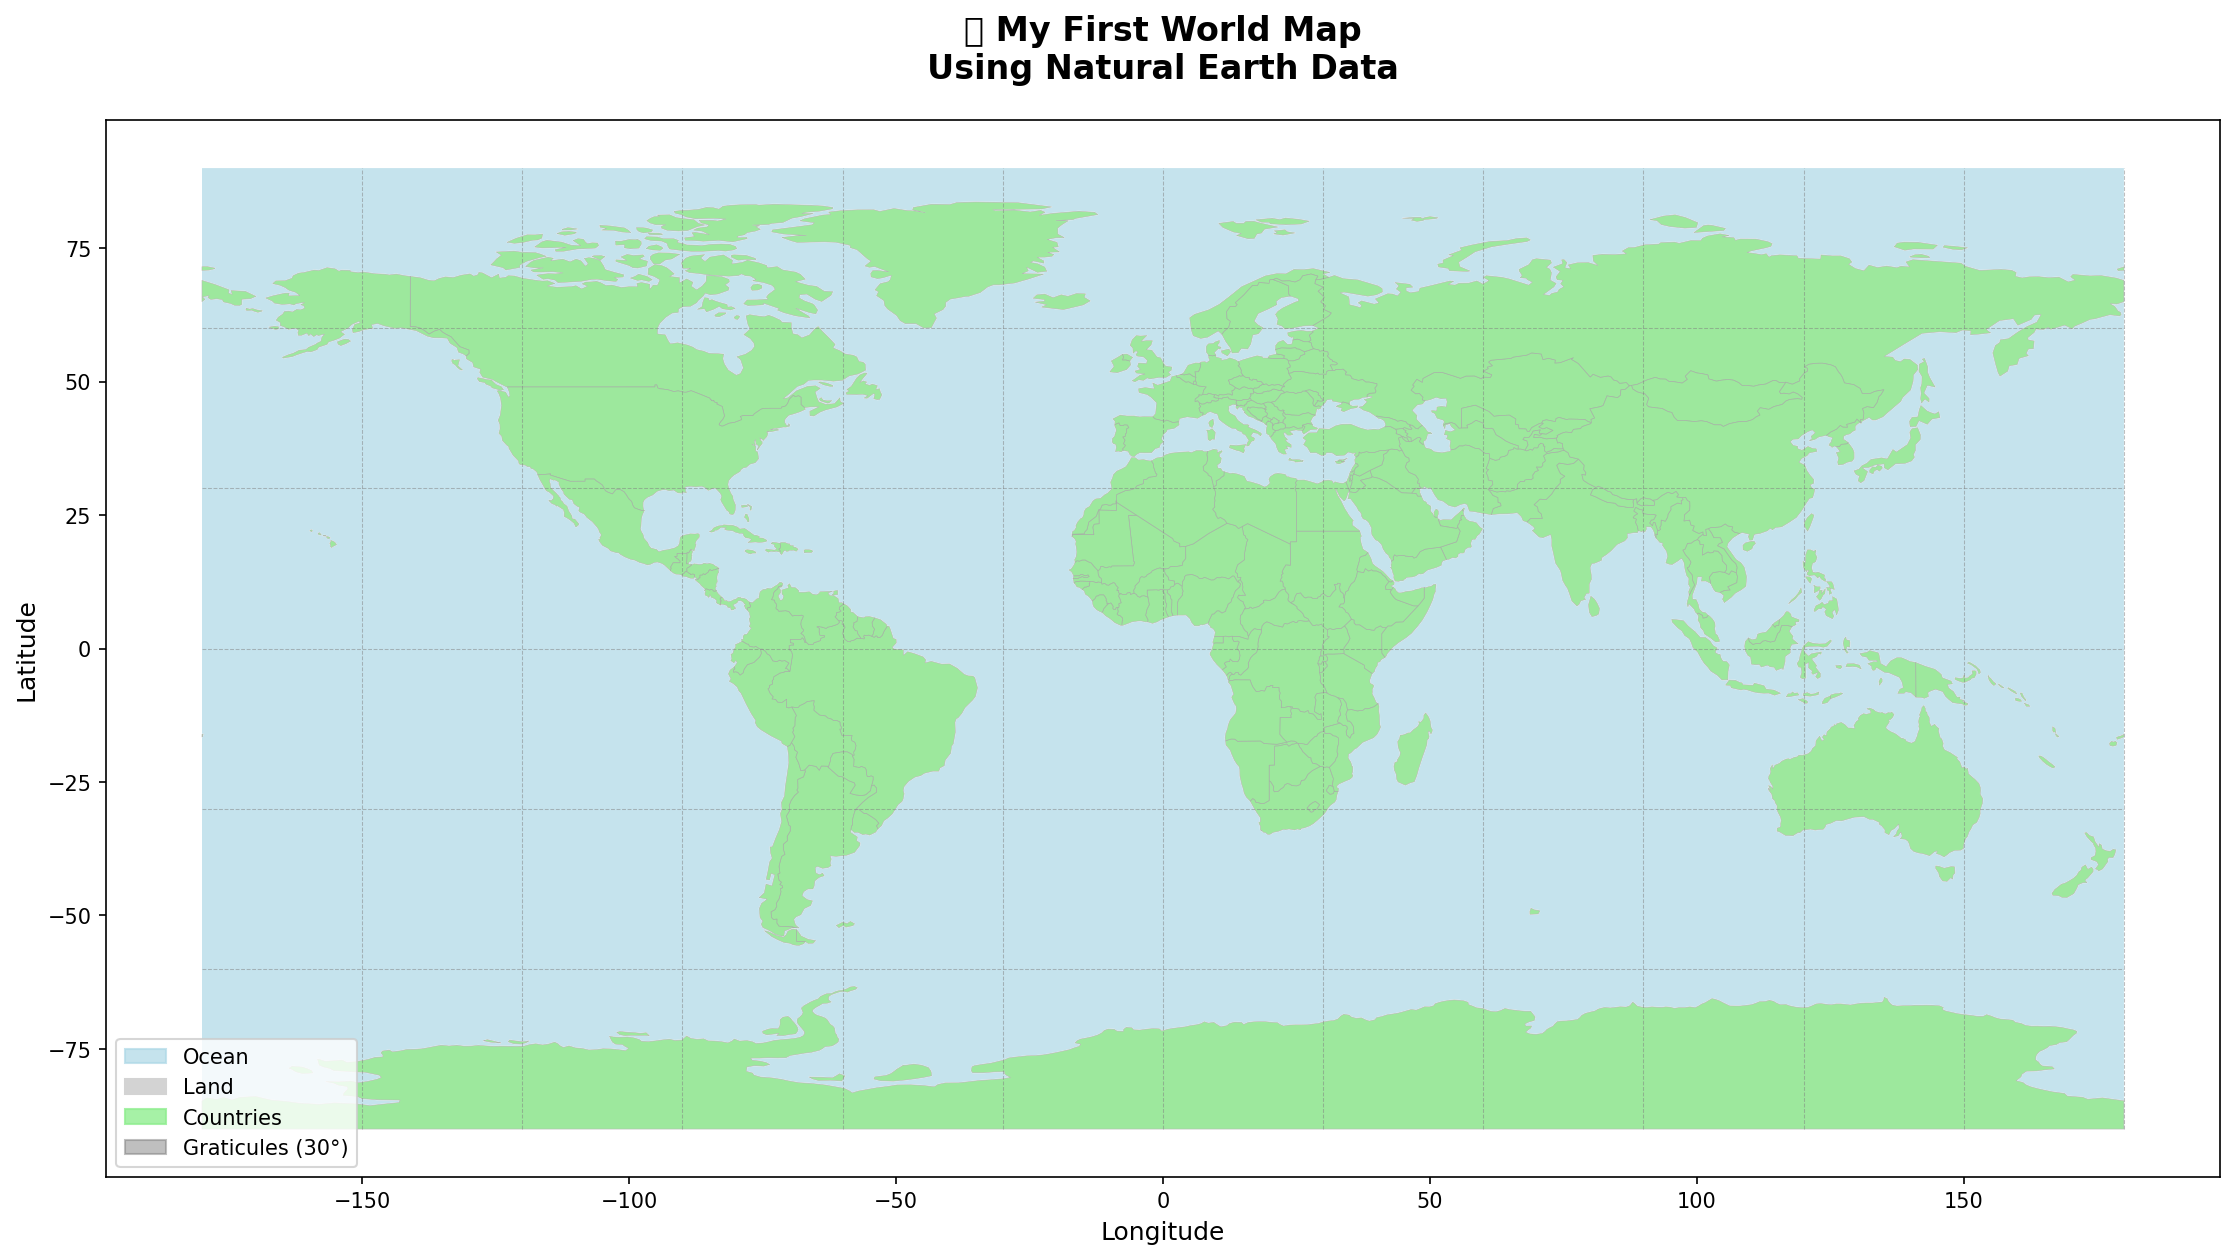

🎉 Congratulations! You've created your first geospatial visualization!
📊 Map Details:
   • 177 countries plotted
   • 127 land polygons
   • Current CRS: EPSG:4326
   • Projection: Geographic (Plate Carrée)


In [6]:
# Create our first world map!
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the base layers
# Ocean first (background)
geodata['ocean'].plot(ax=ax, color='lightblue', alpha=0.7, label='Ocean')

# Land next
geodata['land'].plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.5, label='Land')

# Countries on top with borders
geodata['countries'].plot(ax=ax, color='lightgreen', edgecolor='darkgray', 
                         linewidth=0.3, alpha=0.8, label='Countries')

# Add graticules (latitude/longitude lines) for reference
geodata['graticules_30'].plot(ax=ax, color='gray', linewidth=0.5, alpha=0.5, linestyle='--')

# Style the map
ax.set_title('🌍 My First World Map\nUsing Natural Earth Data', 
             fontsize=16, fontweight='bold', pad=20)

# Remove axis ticks and labels for cleaner look
ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)

# Add a simple legend
legend_elements = [
    mpatches.Patch(color='lightblue', alpha=0.7, label='Ocean'),
    mpatches.Patch(color='lightgray', label='Land'),
    mpatches.Patch(color='lightgreen', alpha=0.8, label='Countries'),
    mpatches.Patch(color='gray', alpha=0.5, label='Graticules (30°)')
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=10)

# Set aspect ratio to equal so the world isn't distorted
ax.set_aspect('equal')

# Adjust layout and show
plt.tight_layout()
plt.show()

print("🎉 Congratulations! You've created your first geospatial visualization!")
print(f"📊 Map Details:")
print(f"   • {len(geodata['countries'])} countries plotted")
print(f"   • {len(geodata['land'])} land polygons")
print(f"   • Current CRS: {geodata['countries'].crs}")
print(f"   • Projection: Geographic (Plate Carrée)")

## 5. Projection Comparison - How Shape Affects Perception

One of the most important concepts in cartography is **map projection**. The world is a 3D sphere, but maps are 2D. Every projection involves trade-offs between:

- **Shape** (conformal projections)
- **Area** (equal-area projections)  
- **Distance** (equidistant projections)
- **Direction** (azimuthal projections)

Let's create a comparison showing the same data in different projections using Cartopy!

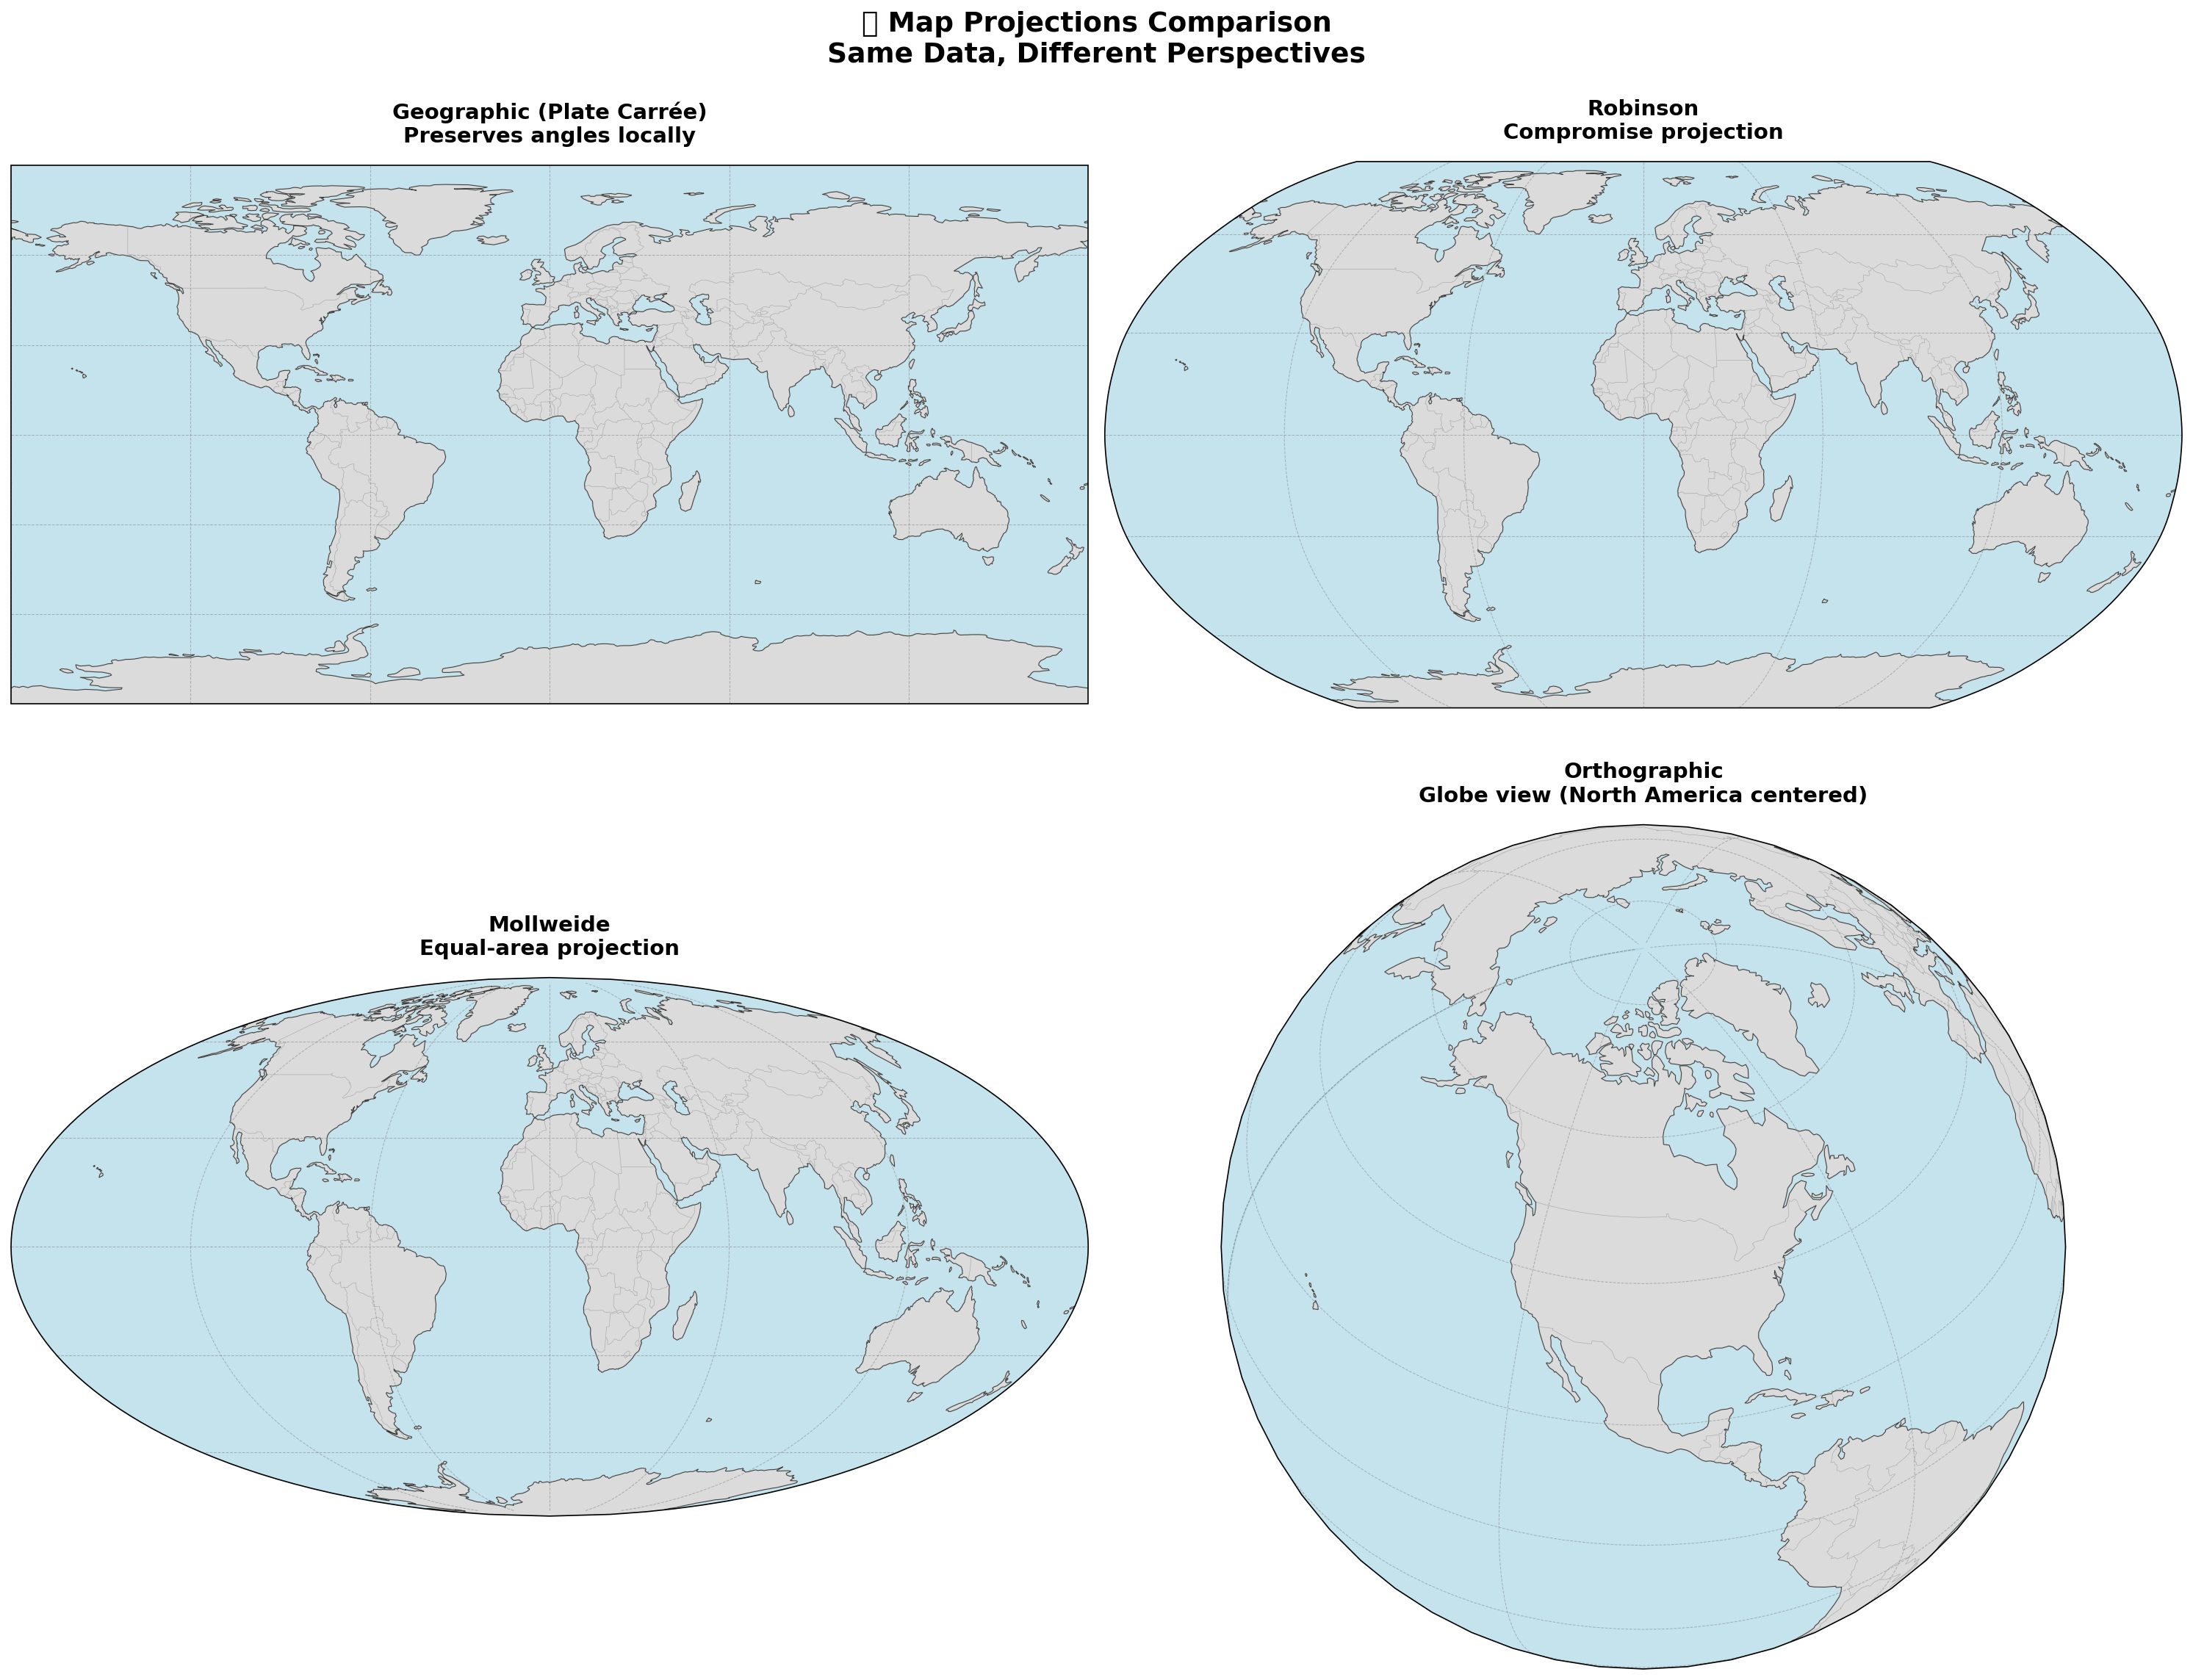

🎯 Key Observations:
   • Plate Carrée: Familiar but distorts polar regions
   • Robinson: Good compromise for world maps
   • Mollweide: Equal-area, good for showing true country sizes
   • Orthographic: Globe view, realistic but shows only one hemisphere

💡 Choose projections based on your analysis goals!


In [7]:
# Create a 2x2 comparison of different projections
fig = plt.figure(figsize=(20, 16))

# Define four different projections to compare
projections = [
    (ccrs.PlateCarree(), "Geographic (Plate Carrée)\nPreserves angles locally"),
    (ccrs.Robinson(), "Robinson\nCompromise projection"),
    (ccrs.Mollweide(), "Mollweide\nEqual-area projection"),
    (ccrs.Orthographic(central_longitude=-100, central_latitude=45), "Orthographic\nGlobe view (North America centered)")
]

# Get countries data for transformation
countries = geodata['countries']
land = geodata['land']

for i, (projection, title) in enumerate(projections, 1):
    ax = fig.add_subplot(2, 2, i, projection=projection)
    
    # Transform and plot countries
    countries_proj = countries.to_crs(projection.proj4_init if hasattr(projection, 'proj4_init') 
                                     else projection.to_proj4())
    land_proj = land.to_crs(projection.proj4_init if hasattr(projection, 'proj4_init') 
                           else projection.to_proj4())
    
    # Add map features using Cartopy
    ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.7)
    ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.8)
    ax.add_feature(cfeature.BORDERS, linewidth=0.3, color='darkgray')
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5, color='black', alpha=0.7)
    
    # Add gridlines for reference (when supported)
    try:
        gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    except:
        pass  # Some projections don't support gridlines
        
    ax.set_title(title, fontsize=14, fontweight='bold', pad=15)
    
    # Set global extent
    ax.set_global()

plt.suptitle('🗺️ Map Projections Comparison\nSame Data, Different Perspectives', 
             fontsize=18, fontweight='bold', y=0.95)

plt.tight_layout()
plt.show()

print("🎯 Key Observations:")
print("   • Plate Carrée: Familiar but distorts polar regions")
print("   • Robinson: Good compromise for world maps")
print("   • Mollweide: Equal-area, good for showing true country sizes")
print("   • Orthographic: Globe view, realistic but shows only one hemisphere")
print("\n💡 Choose projections based on your analysis goals!")

## 6. Save Your Maps & Next Steps

Let's save our beautiful maps for future use and summarize what we've learned!

💾 Map saved to: ../outputs/figures/world_map_final.png


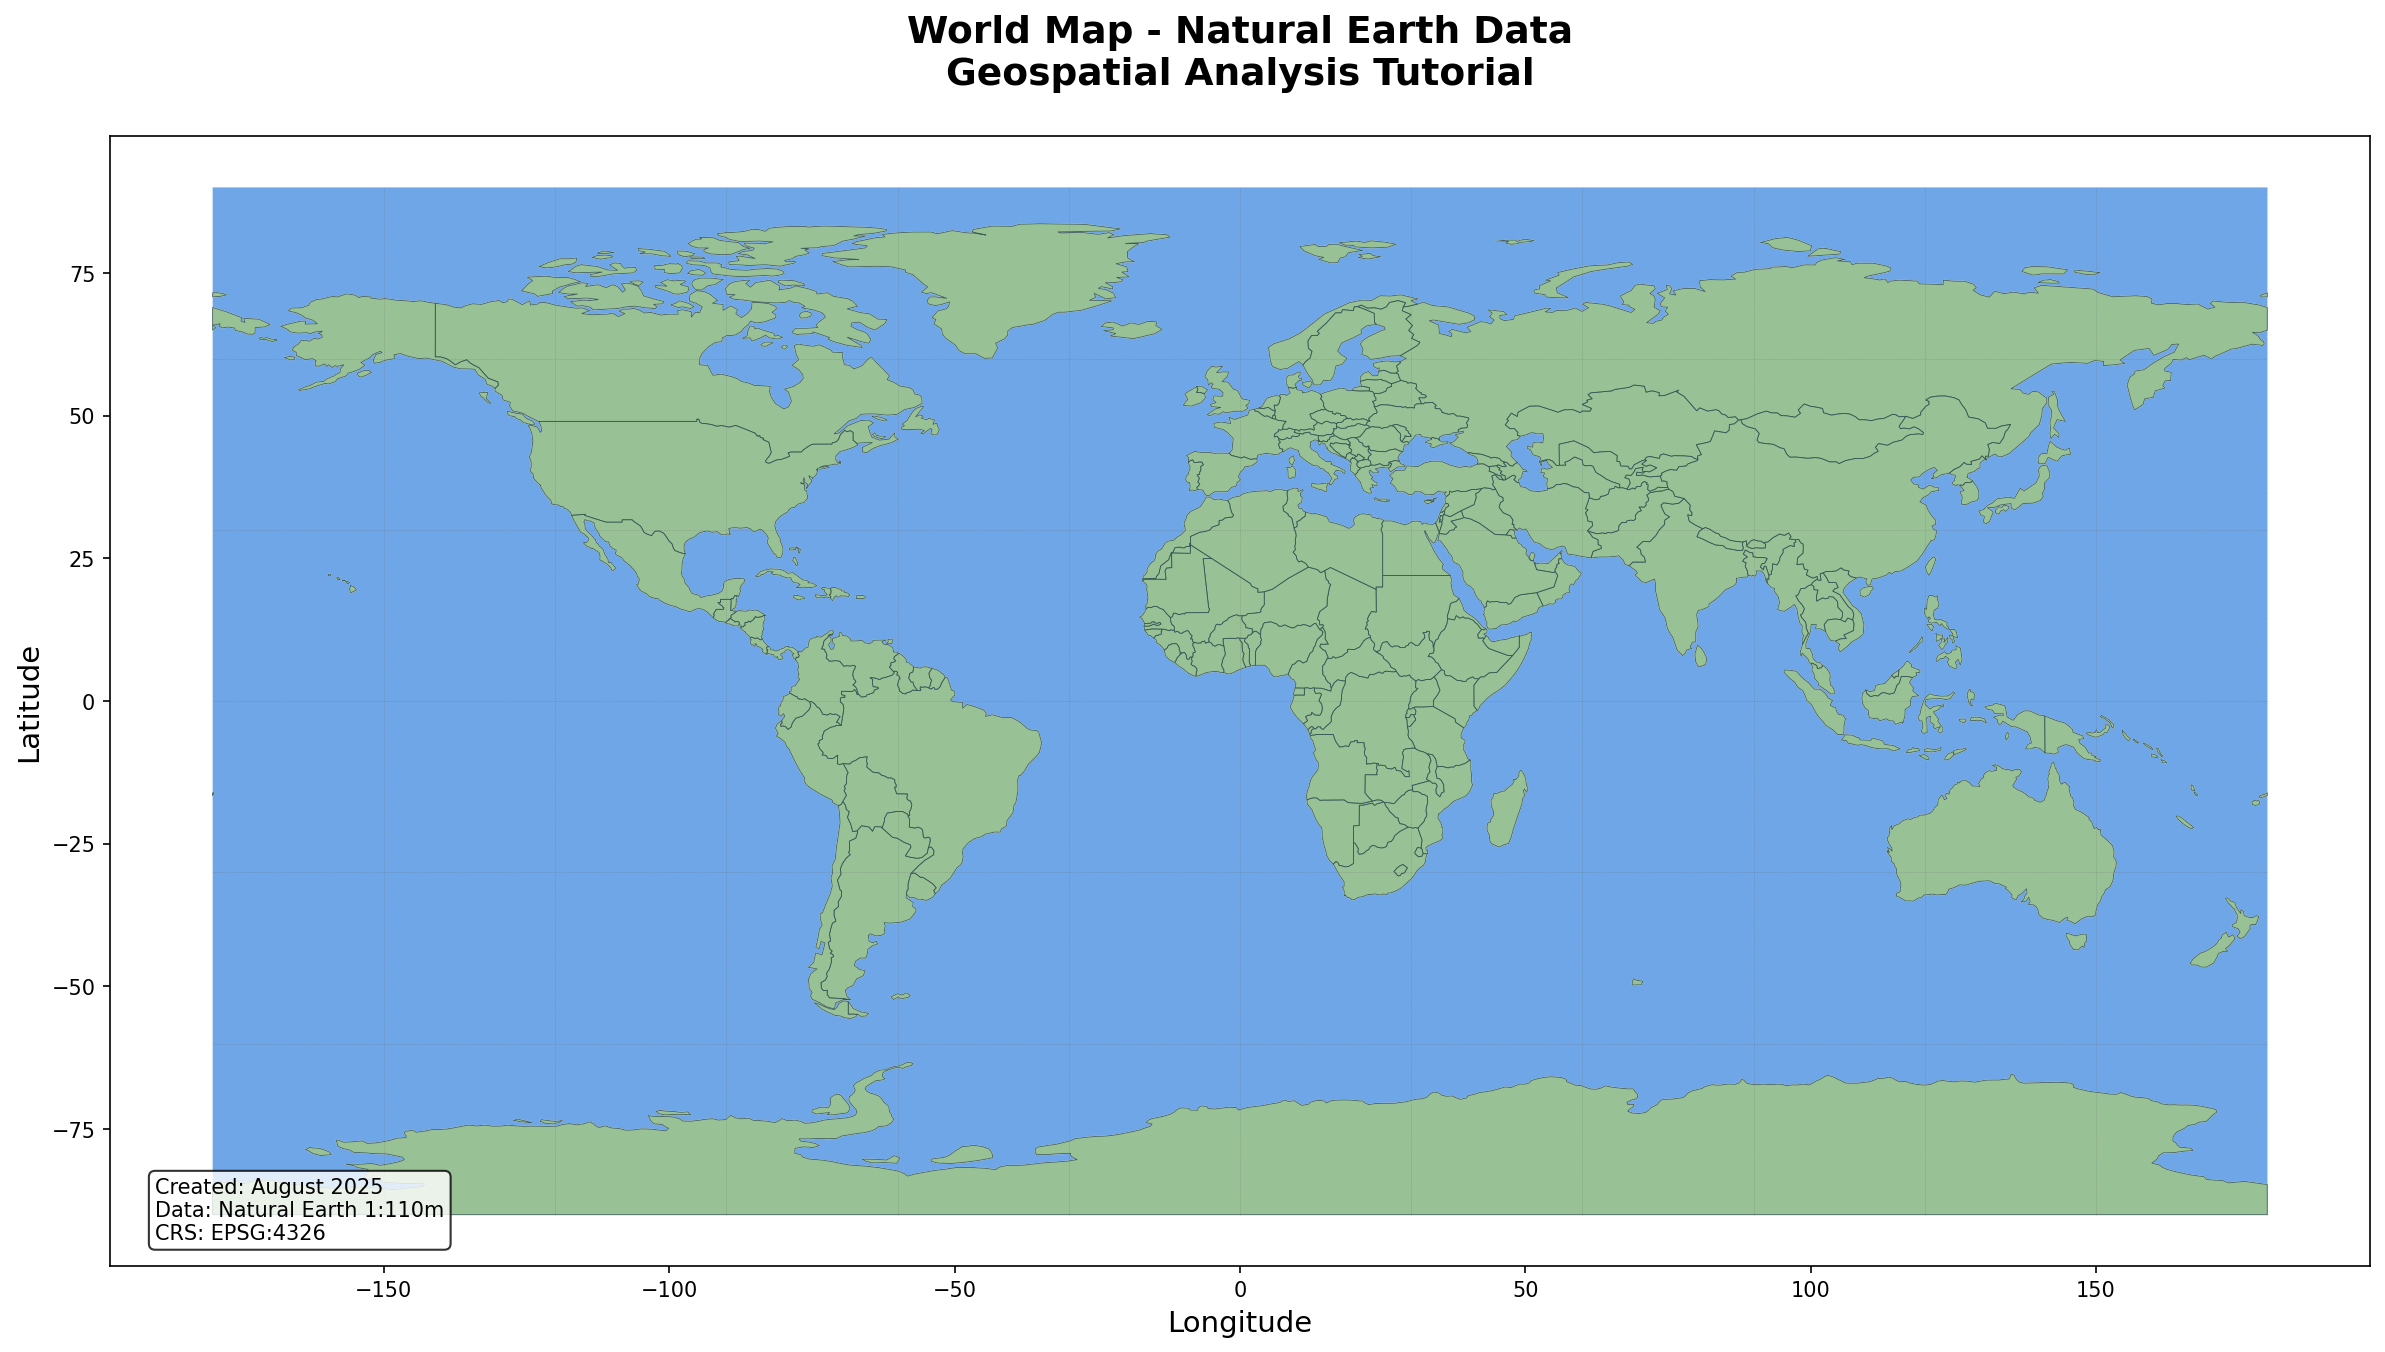


🎉 TUTORIAL COMPLETE! What We Accomplished:
✅ Environment Setup: 4 datasets loaded successfully
✅ Data Download: File size checking (all under 500MB limit)
✅ Basic Mapping: Created world map with 177 countries
✅ Projection Comparison: Explored 4 different map projections
✅ Professional Output: High-resolution map saved

📚 Key Concepts Learned:
   • Coordinate Reference Systems (CRS)
   • Map projections and their trade-offs
   • Geospatial data visualization with GeoPandas
   • Natural Earth as a data source
   • File size management for large datasets
   • Professional cartographic design principles

📁 Files Created:
   • Notebook: /Users/sanjeevadodlapati/Downloads/Repos/GeoSpatialAI/projects/project_0_cartography_practice/notebooks/test.ipynb
   • Final Map: /Users/sanjeevadodlapati/Downloads/Repos/GeoSpatialAI/projects/project_0_cartography_practice/notebooks/../outputs/figures/world_map_final.png
   • Project Structure: Ready for more geospatial projects!

🚀 Ready for the next tut

In [8]:
# Create a final publication-quality world map to save
fig, ax = plt.subplots(1, 1, figsize=(16, 10))

# Plot with improved styling
geodata['ocean'].plot(ax=ax, color='#4A90E2', alpha=0.8)  # Nice blue
geodata['land'].plot(ax=ax, color='#F5F5DC', edgecolor='white', linewidth=0.5)  # Beige
geodata['countries'].plot(ax=ax, color='#8FBC8F', edgecolor='#2F4F4F', 
                         linewidth=0.4, alpha=0.9)  # Light green with dark borders

# Add graticules
geodata['graticules_30'].plot(ax=ax, color='#696969', linewidth=0.3, alpha=0.6, linestyle=':')

# Professional styling
ax.set_title('World Map - Natural Earth Data\nGeospatial Analysis Tutorial', 
             fontsize=18, fontweight='bold', pad=25)
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)

# Add metadata text
metadata_text = f"Created: August 2025\nData: Natural Earth 1:110m\nCRS: {geodata['countries'].crs}"
ax.text(0.02, 0.02, metadata_text, transform=ax.transAxes, fontsize=10, 
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
        verticalalignment='bottom')

ax.set_aspect('equal')
plt.tight_layout()

# Save the map in high resolution
output_path = figures_dir / 'world_map_final.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"💾 Map saved to: {output_path}")

plt.show()

# Summary of what we accomplished
print("\n" + "="*60)
print("🎉 TUTORIAL COMPLETE! What We Accomplished:")
print("="*60)
print(f"✅ Environment Setup: {len(geodata)} datasets loaded successfully")
print(f"✅ Data Download: File size checking (all under {max_size_mb}MB limit)")
print(f"✅ Basic Mapping: Created world map with {len(geodata['countries'])} countries")
print(f"✅ Projection Comparison: Explored 4 different map projections")
print(f"✅ Professional Output: High-resolution map saved")
print("\n📚 Key Concepts Learned:")
print("   • Coordinate Reference Systems (CRS)")
print("   • Map projections and their trade-offs")
print("   • Geospatial data visualization with GeoPandas")
print("   • Natural Earth as a data source")
print("   • File size management for large datasets")
print("   • Professional cartographic design principles")
print(f"\n📁 Files Created:")
print(f"   • Notebook: {Path('test.ipynb').absolute()}")
print(f"   • Final Map: {output_path.absolute()}")
print(f"   • Project Structure: Ready for more geospatial projects!")

print(f"\n🚀 Ready for the next tutorial in the geospatial series!")
print("Next up: More advanced cartography, data analysis, or machine learning applications.")